# Autotalker Tutorial

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 01.10.2022
- **Date of Last Modification:** 29.11.2022

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import os
import random
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context

from autotalker.benchmarking import (compute_avg_cad,
                                     compute_cad,
                                     compute_cell_cat_cls_accuracy,
                                     compute_avg_gcd,
                                     compute_max_lnmi,
                                     compute_per_cell_log_rclisi)
from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps)

### 1.2 Configure Paths and Create Directories

In [3]:
# Define paths
gp_data_folder_path = "datasets/gp_data/" # gene program data
srt_data_folder_path = "datasets/srt_data/" # spatially resolved transcriptomics data
srt_data_bronze_folder_path = f"{srt_data_folder_path}/bronze"
srt_data_silver_folder_path = f"{srt_data_folder_path}/silver"
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "omnipath_lr_interactions.csv"

# Create required directories
os.makedirs("mlruns", exist_ok=True)
os.makedirs(gp_data_folder_path, exist_ok=True)
os.makedirs(srt_data_bronze_folder_path, exist_ok=True)
os.makedirs(srt_data_silver_folder_path, exist_ok=True)
os.makedirs(srt_data_gold_folder_path, exist_ok=True)

### 1.3 Run Notebook Setup

In [4]:
# Define default matplotlib figure size
matplotlib.rcParams["figure.figsize"] = (5, 5)

In [5]:
# Ignore future warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [6]:
# Get time of notebook execution for timestamping saved artefacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

In [7]:
# Set random seed
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

### 1.4 Define Parameters

**Note:** ´edge_batch_size´ is a very important hyperparameter. Training does not work when it is too small because the gradients will be too noisy. If it is too high, you might run into GPU memory constraints.

In [15]:
## Dataset
dataset = "squidpy_seqfish_mouse_organogenesis"
#dataset = "squidpy_slideseqv2_mouse_hippocampus"
#dataset = "vizgen_merfish_mouse_brain"
#dataset = "vizgen_merfish_mouse_liver" 
#dataset = "vizgen_merfish_human_liver_cancer"
#dataset = "10x_xenium_human_breast_cancer"
#dataset = "starmap_plus_mouse_cns"
#dataset = "eel_fish_mouse_brain"
n_neighs = 8 # for spatial neighborhood graph; constrained by GPU memory

## Model
# adata Keys
counts_key = "counts"
adj_key = "spatial_connectivities"
spatial_key = "spatial"
gp_names_key = "autotalker_gp_names"
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
latent_key = "autotalker_latent"

# Neighborhood Gene Expression Aggregation (Node Label Method)
#node_label_method = "self" # does only apply for fully-connected GPs
#node_label_method = "one-hop-sum"
#node_label_method = "one-hop-norm"
node_label_method = "one-hop-attention"

# Architecture
n_latent_fc_gps = 512 # does only apply for fully-connected GPs
include_edge_recon_loss = True
include_gene_expr_recon_loss = True
gene_expr_recon_dist = "nb"
active_gp_thresh_ratio = 0.1
dropout_rate_encoder = 0.
dropout_rate_graph_decoder = 0.

# Trainer
n_epochs = 10
n_epochs_no_edge_recon = 1
lr = 0.01
weight_decay = 0.
lambda_edge_recon = None
lambda_gene_expr_recon = 1.
lambda_group_lasso = 0.1
lambda_l1_addon = 1.
edge_val_ratio = 0.1
edge_test_ratio = 0.05
node_val_ratio = 0.1
edge_batch_size = 64
node_batch_size = 128

## 2. Data

### 2.1 Load & Preprocess Data

#### 2.1.1 Squidpy seqFISH Mouse Organogenesis Dataset

- **Publication:** Lohoff, T. et al. Highly multiplexed spatially resolved gene expression profiling of mouse organogenesis. bioRxiv 2020.11.20.391896 (2020). [doi:10.1101/2020.11.20.391896](https://doi.org/10.1101/2020.11.20.391896)
- **Data Access:** Preprocessed version from squidpy API (original source https://marionilab.cruk.cam.ac.uk/SpatialMouseAtlas/)
- **Summary:**
    - Sagittal tissue section of 8-12 somite-stage mouse embryo
    - 19,416 observations on cell-level with cell-type annotations
    - 351 probed genes

In [9]:
if dataset == "squidpy_seqfish_mouse_organogenesis":
    print(f"Loading and preprocessing dataset '{dataset}'.")
    
    # Retrieve adata from squidpy
    adata = sq.datasets.seqfish()
    
    # Store raw counts in `layers`
    adata.layers["counts"] = adata.X.copy()
    
    # Determine cell annotation (pre-annotated)
    cell_type_key = "celltype_mapped_refined"
    
    # Change cell annotation colors
    color_list = ["#d8d4d6", # Allantois
                  "#800000", # Anterior somitic tissues
                  "#805500", # Cardiomyocytes
                  "#ffaa00", # Cranial mesoderm
                  "#558000", # Definitive endoderm
                  "#aaff00", # Dermomyotome
                  "#ff0000", # Endothelium
                  "#b3ffb3", # Erythroid
                  "#008055", # Forebrain/Midbrain/Hindbrain
                  "#00ffaa", # Gut tube
                  "#005580", # Haematoendothelial progenitors
                  "#00aaff", # Intermediate mesoderm
                  "#000080", # Lateral plate mesoderm
                  "#0000ff", # Low quality
                  "#550080", # Mixed mesenchymal mesoderm
                  "#aa00ff", # Neural crest
                  "#800055", # NMP
                  "#ff00aa", # Presomitic mesoderm
                  "#80ffff", # Sclerotome
                  "#ff8080", # Spinal cord
                  "#000000", # Splanchnic mesoderm
                  "#ffff80"] # Surface ectoderm
    adata.uns["celltype_mapped_refined_colors"] = color_list
        
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key=spatial_key, n_neighs=n_neighs)
    
    # Store data to disk
    adata.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")
    
else:
    print("No action taken.")

Loading and preprocessing dataset 'squidpy_seqfish_mouse_organogenesis'.


#### 2.1.2 Squidpy Slide-seqV2 Mouse Hippocampus Dataset

- **Publication**: Stickels, R. R. et al. Highly sensitive spatial transcriptomics at near-cellular resolution with Slide-seqV2. Nat. Biotechnol. 39, 313–319 (2021). [doi:10.1038/s41587-020-0739-1](https://doi.org/10.1038/s41587-020-0739-1)
- **Data Access:** Preprocessed version from squidpy API (original source https://singlecell.broadinstitute.org/single_cell/study/SCP815/highly-sensitive-spatial-transcriptomics-at-near-cellular-resolution-with-slide-seqv2)
- **Summary:**
    - Mouse hippocampus puck
    - 41,786 observations on cell-level with cell-type annotations
    - 4,000 probed genes

In [ ]:
if dataset == "squidpy_slideseqv2_mouse_hippocampus":
    print(f"Loading and preprocessing dataset '{dataset}'.")
    
    # Retrieve adata from squidpy
    adata = sq.datasets.slideseqv2()
    
    # Store raw counts in `layers`
    adata.layers["counts"] = adata.X.copy()
    
    # Determine cell annotation (pre-annotated)
    cell_type_key = "cluster"
        
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key=spatial_key, n_neighs=n_neighs)
    
    # Store data to disk
    adata.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")
    
else:
    print("No action taken.")

#### 2.1.3 Vizgen MERFISH Mouse Brain Receptor Dataset

- **Publication:** Vizgen Data Release V1.0. May 2021
- **Data Access:** https://info.vizgen.com/mouse-brain-map?submissionGuid=a66ccb7f-87cf-4c55-83b9-5a2b6c0c12b9
    - Slice 1 Replicate 1
        - cell_by_gene_S1R1.csv
        - cell_metadata_S1R1.csv
- **Preprocessing Vignette:** https://squidpy.readthedocs.io/en/latest/external_tutorials/tutorial_vizgen.html
- **Summary:**
    - Coronal section of mouse brain receptor map
    - 78,329 observations on cell-level without annotations
    - 649 probed genes

In [ ]:
if dataset == "vizgen_merfish_mouse_brain":
    print(f"Loading and preprocessing dataset '{dataset}'.")

    # Read adata from files
    merfish_dir = f"{srt_data_bronze_folder_path}/merfish/"
    adata = sq.read.vizgen(path=merfish_dir,
                           counts_file="datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate1_cell_by_gene_S1R1.csv",
                           meta_file="datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate1_cell_metadata_S1R1.csv")

    # Preprocess as per squidpy vignette
    adata.var_names.unique()
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=(50, 100, 200, 300), inplace=True)
    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    sns.histplot(adata.obs["total_counts"],
                 kde=False,
                 ax=axs[0])
    sns.histplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000],
                 kde=False,
                 bins=40,
                 ax=axs[1])
    sns.histplot(adata.obs["n_genes_by_counts"],
                 kde=False,
                 bins=60,
                 ax=axs[2])
    sns.histplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
                 kde=False,
                 bins=60,
                 ax=axs[3])
    sc.pp.filter_cells(adata, min_counts=10)
    sc.pp.filter_genes(adata, min_cells=10)
    
    # Store raw counts in `layers`
    adata.layers["counts"] = adata.X.copy()
    
    # Store data to disk
    adata.write(f"{srt_data_silver_folder_path}/{dataset}.h5ad")
    
    # Determine cell annotation as per squidpy vignette
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=4000)
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
    cell_type_key = "leiden"
    sc.pl.umap(adata,
               color=["total_counts", "n_genes_by_counts", "leiden",])
    
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key=spatial_key, n_neighs=n_neighs)
    
    # Store data to disk
    adata.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")
    
else:
    print("No action taken.")

#### 2.1.4 Vizgen MERFISH Mouse Liver Dataset

- **Publication**: Vizgen MERFISH Mouse Liver Map January 2022
- **Data Access:** https://info.vizgen.com/mouse-liver-access
    - Animal 1 replicate 1
        - cell_by_gene.csv
        - cell_metadata.csv
- **Preprocessing Vignette:** https://squidpy.readthedocs.io/en/latest/external_tutorials/tutorial_vizgen_mouse_liver.html
- **Summary:**
    - Liver tissue section of mouse liver map
    - 367,335 observations on cell-level without annotations
    - 385 probed genes

In [ ]:
if dataset == "vizgen_merfish_mouse_liver":
    print(f"Loading and preprocessing dataset '{dataset}'.")
    
    # Read adata from files
    merfish_dir = f"{srt_data_bronze_folder_path}/merfish/"
    adata = sq.read.vizgen(merfish_dir,
                           counts_file="Liver1Slice1_cell_by_gene.csv",
                           meta_file="Liver1Slice1_cell_metadata.csv")
    
    # Preprocess as per squidpy vignette
    adata.var_names_make_unique()
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"],percent_top=(50, 100, 200, 300), inplace=True)
    sc.pp.filter_cells(adata, min_counts=50)
    sc.pp.filter_genes(adata, min_cells=10)
    
    # Store raw counts in `layers`
    adata.layers["counts"] = adata.X.copy()
    
    # Store data to disk
    adata.write(f"{srt_data_silver_folder_path}/{dataset}.h5ad")
    
    # Determine cell annotation as per squidpy vignette
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=1.5)
    
    sc.set_figure_params(figsize=(10,10))
    sc.pl.umap(adata, color=["leiden"], size=5)
    
    gene_panel = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41421-021-00266-1/MediaObjects/41421_2021_266_MOESM1_ESM.xlsx"
    df_ref_panel_ini = pd.read_excel(gene_panel, index_col=0)
    df_ref_panel = df_ref_panel_ini.iloc[1:,:1]
    df_ref_panel.index.name = None
    df_ref_panel.columns = ["Function"]
    
    # Assign marker gene metadata using reference dataset
    marker_genes = df_ref_panel[df_ref_panel["Function"].str.contains("marker")].index.tolist()
    
    meta_gene = deepcopy(adata.var)
    common_marker_genes = list(set(meta_gene.index.tolist()).intersection(marker_genes))
    meta_gene.loc[common_marker_genes, "Markers"] = df_ref_panel.loc[common_marker_genes, "Function"]
    meta_gene["Markers"] = meta_gene["Markers"].apply(lambda x: "N.A." if "marker" not in str(x) else x)
    meta_gene["Markers"].value_counts()
    
    ser_counts = adata.obs["leiden"].value_counts()
    ser_counts.name = "cell counts"
    meta_leiden = pd.DataFrame(ser_counts)
    
    cat_name = "leiden"
    sig_leiden = pd.DataFrame(columns=adata.var_names, index=adata.obs[cat_name].cat.categories)
    for clust in adata.obs[cat_name].cat.categories:
        sig_leiden.loc[clust] = adata[adata.obs[cat_name].isin([clust]),:].X.mean(0)
    sig_leiden = sig_leiden.transpose()
    leiden_clusters = ["Leiden-" + str(x) for x in sig_leiden.columns.tolist()]
    sig_leiden.columns = leiden_clusters
    meta_leiden.index = sig_leiden.columns.tolist()
    meta_leiden["leiden"] = pd.Series(meta_leiden.index.tolist(), index=meta_leiden.index.tolist())
    
    meta_gene = pd.DataFrame(index=sig_leiden.index.tolist())
    meta_gene["info"] = pd.Series("", index=meta_gene.index.tolist())
    meta_gene["Markers"] = pd.Series("N.A.", index=sig_leiden.index.tolist())
    meta_gene.loc[common_marker_genes, "Markers"] = df_ref_panel.loc[common_marker_genes, "Function"]
    
    meta_leiden["Cell_Type"] = pd.Series("N.A.", index=meta_leiden.index.tolist())
    num_top_genes = 30
    for inst_cluster in sig_leiden.columns.tolist():
        top_genes = sig_leiden[inst_cluster].sort_values(ascending=False).index.tolist()[:num_top_genes]
    
        inst_ser = meta_gene.loc[top_genes, "Markers"]
        inst_ser = inst_ser[inst_ser != "N.A."]
        ser_counts = inst_ser.value_counts()
      
        max_count = ser_counts.max()
      
        max_cat = "_".join(sorted(ser_counts[ser_counts == max_count].index.tolist()))
        max_cat = max_cat.replace(" marker", "").replace(" ", "-")
      
        print(inst_cluster, max_cat)
        meta_leiden.loc[inst_cluster, "Cell_Type"] = max_cat
    
    # Rename clusters
    meta_leiden["name"] = meta_leiden.apply(lambda x: x["Cell_Type"] + "_" + x["leiden"] , axis=1)
    leiden_names = meta_leiden["name"].values.tolist()
    meta_leiden.index = leiden_names
    
    # Transfer cell type labels to single cells
    leiden_to_cell_type = deepcopy(meta_leiden)
    leiden_to_cell_type.set_index("leiden", inplace=True)
    leiden_to_cell_type.index.name = None
    
    adata.obs["Cell_Type"] = adata.obs["leiden"].apply(lambda x: leiden_to_cell_type.loc["Leiden-" + str(x), "Cell_Type"])
    adata.obs["Cluster"] = adata.obs["leiden"].apply(lambda x: leiden_to_cell_type.loc["Leiden-" + str(x), "name"])
    cell_type_key = "Cell_Type"
    
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key=spatial_key, n_neighs=n_neighs)
    
    # Store data to disk
    adata.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")
    
else:
    print("No action taken.")

#### 2.1.5 Vizgen MERFISH Human Liver Cancer Dataset

- **Publication:** Vizgen MERFISH FFPE Human Immuno-oncology Data Set,  May 2022
- **Data Access:** https://info.vizgen.com/ffpe-showcase?submissionGuid=bbe0d6ca-92ad-4257-bdcd-cbc6dee8219b
    - Liver cancer 1
        - cell_by_gene.csv
        - cell_metadata.csv
- **Summary:**
    - FFPE tissue section of human liver cancer
    - 480,592 observations on cell-level without annotations
    - 500 probed genes

In [ ]:
if dataset == "vizgen_merfish_human_liver_cancer":
    print(f"Loading and preprocessing dataset '{dataset}'.")
    
    # Read counts and remove blank genes
    vizgen_dir = f"{srt_data_bronze_folder_path}/merfish/"
    adata = ad.read_text(vizgen_dir + "HumanLiverCancerPatient1_cell_by_gene.csv" ,delimiter=",", first_column_names=True)
    blank_genes = np.array(["Blank" in v for v in adata.var_names])
    adata.obsm["blank_genes"] = pd.DataFrame(adata[:, blank_genes].X.copy(), columns=adata.var_names[blank_genes], index=adata.obs_names)
    adata = adata[:, ~blank_genes].copy()
    adata.X = sp.csr_matrix(adata.X)
    
    # Read metadata and align index for join
    metadata = pd.read_csv(vizgen_dir + "HumanLiverCancerPatient1_cell_metadata.csv", header=0, index_col=0)
    metadata.sort_index(inplace=True)
    metadata.index = metadata.index.astype("str")
    
    # Join counts with obs and store spatial coordinates
    adata.obs = pd.merge(adata.obs, metadata, how="left", left_index=True, right_index=True)
    adata.obsm["spatial"] = adata.obs[["center_x", "center_y"]].values
    adata.obs.drop(columns=["center_x", "center_y"], inplace=True)
    
    # Preprocess
    adata.var_names_make_unique()
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=(50, 100, 200, 300), inplace=True)
    sc.pp.filter_cells(adata, min_counts=50)
    sc.pp.filter_genes(adata, min_cells=10)
    
    # Store raw counts in `layers`
    adata.layers["counts"] = adata.X.copy()
    
    # Store data to disk
    adata.write(f"{srt_data_silver_folder_path}/{dataset}.h5ad")
    
    # Determine cell annotation
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
    sc.pl.umap(adata,
               color=["total_counts", "n_genes_by_counts", "leiden"])
    cell_type_key = "leiden"
    
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key=spatial_key, n_neighs=n_neighs)
    
    # Store data to disk
    adata.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")
    
else:
    print("No action taken.")

#### 2.1.6 10x Genomics Xenium Human Breast Cancer Tumor Microenvironment Dataset

- **Publication:** Janesick, A. et al. High resolution mapping of the breast cancer tumor microenvironment using integrated single cell, spatial and in situ analysis of FFPE tissue. bioRxiv 2022.10.06.510405 (2022). [doi:10.1101/2022.10.06.510405](https://doi.org/10.1101/2022.10.06.510405)
- **Data Access:** https://www.10xgenomics.com/products/xenium-in-situ/preview-dataset-human-breast
    - Feature-cell matrix (HDF5)
    - Cell summary file (CSV) -> unpack with ```gzip -d Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz```
- **Preprocessing Vignette:** https://squidpy.readthedocs.io/en/latest/external_tutorials/tutorial_xenium.html
- **Summary**:
    - FFPE tissue section of human breast cancer
    - 164,079 observations on cell-level without annotations
    - 313 probed genes

In [ ]:
if dataset == "10x_xenium_human_breast_cancer":
    print(f"Loading and preprocessing dataset '{dataset}'.")
    
    # Read adata from file and add metadata
    xenium_dir = f"{srt_data_bronze_folder_path}/xenium/"
    adata = sc.read_10x_h5(filename=xenium_dir + "Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5")
    metadata = pd.read_csv(xenium_dir + "Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv")
    metadata.set_index(adata.obs_names, inplace=True)
    adata.obs = metadata.copy()
    
    # Preprocess as per squidpy vignette
    adata.var_names_make_unique()
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"],percent_top=(50, 100, 200, 300), inplace=True)
    sc.pp.filter_cells(adata, min_counts=10)
    sc.pp.filter_genes(adata, min_cells=5)
    
    # Store counts in `layers` and spatial coords in `obsm`
    adata.layers["counts"] = adata.X.copy()
    adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()
    
    # Store data to disk
    adata.write(f"{srt_data_silver_folder_path}/{dataset}.h5ad")
    
    # Determine cell annotation as per squidpy vignette
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
    cell_type_key = "leiden"
    
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key=spatial_key, n_neighs=n_neighs)
    
    # Store data to disk
    adata.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")
    
else:
    print("No action taken.")

#### 2.1.7 STARmap PLUS Mouse Central Nervous System Dataset

- **Publication:** Shi, H. et al. Spatial Atlas of the Mouse Central Nervous System at Molecular Resolution. bioRxiv 2022.06.20.496914 (2022). [doi:10.1101/2022.06.20.496914](https://doi.org/10.1101/2022.06.20.496914)
- **Data Access:** https://singlecell.broadinstitute.org/single_cell/study/SCP1830
    - Sagittal 1 (Slice 3)
        - sagittal1_spatial.csv
        - sagittal1raw_expression_pd.csv
- **Summary:**
    - Sagittal section of mouse brain
    - 91,246 observations on cell-level with cell-type annotations
    - 1022 genes

In [ ]:
if dataset == "starmap_plus_mouse_cns":
    print(f"Loading and preprocessing dataset '{dataset}'.")
    
    # Read counts and metadata and change format
    starmap_plus_dir = f"{srt_data_bronze_folder_path}/starmap_plus/"
    metadata = pd.read_csv(starmap_plus_dir + "sagittal1_spatial.csv", skiprows=[1])
    counts = pd.read_csv(starmap_plus_dir + "sagittal1raw_expression_pd.csv")
    counts.set_index("GENE", inplace=True)
    metadata.set_index("NAME", inplace=True)
    counts = counts.T
    
    # Merge counts with metadata and store counts in `layers` and spatial coords in `obsm`
    adata = ad.AnnData(counts, dtype=np.float32)
    adata.obs = pd.merge(adata.obs, metadata, how="left", left_index=True, right_index=True)
    adata.obsm["spatial"] = adata.obs[["X", "Y"]].values / 1000 # smaller scale for plotting with squidpy
    adata.obs.drop(columns=["X", "Y", "Z"], inplace=True)
    adata.layers["counts"] = adata.X.copy()
    
    # Determine cell annotation
    cell_type_key = "Maintype_Symbol"
    
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key=spatial_key
                            , n_neighs=n_neighs)
    
    # Store data to disk
    adata.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")
    
else:
    print("No action taken.")

#### 2.1.8 EEL FISH Mouse Brain Dataset

- **Publication:** Borm, L. E. et al. Scalable in situ single-cell profiling by electrophoretic capture of mRNA using EEL FISH. Nat. Biotechnol. (2022) [doi:10.1038/s41587-022-01455-3](https://doi.org/10.1038/s41587-022-01455-3)
- **Data Accress:** https://figshare.com/articles/dataset/EEL_Mouse_440_genes_single_cell_data/20310771
    - LBEXP20210718_EEL_Mouse_448_2_20220512.h5ad
- **Summary:**
    - Sagittal mouse brain section
    - 127,591 observations on cell-level with cluster annotations 
    - 440 genes

In [ ]:
if dataset == "eel_fish_mouse_brain":
    print(f"Loading and preprocessing dataset '{dataset}'.")
    
    # Read adata from file
    eel_fish_dir = f"{srt_data_bronze_folder_path}/eel_fish/"
    adata = sc.read_h5ad(eel_fish_dir + "LBEXP20210718_EEL_Mouse_448_2_20220512.h5ad")
    
    # Store counts in `layers` and spatial coords in `obsm`
    adata.obsm["spatial"] = adata.obs[["X", "Y"]].values # smaller scale for plotting with squidpy
    adata.obs.drop(columns=["X", "Y", "X_um", "Y_um"], inplace=True)
    adata.layers["counts"] = adata.X.copy()
    
    # Determine cell annotation
    cell_type_key = "Clusters"
    
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key=spatial_key, n_neighs=n_neighs)
    
    # Store data to disk
    adata.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")
    
else:
    print("No action taken.")

### 2.2 Explore Data

Using dataset squidpy_seqfish_mouse_organogenesis.
Number of nodes (cells): 19416
Number of node features (genes): 351
Average number of edges per node: 8.0
Number of total edges: 78058
--------------------


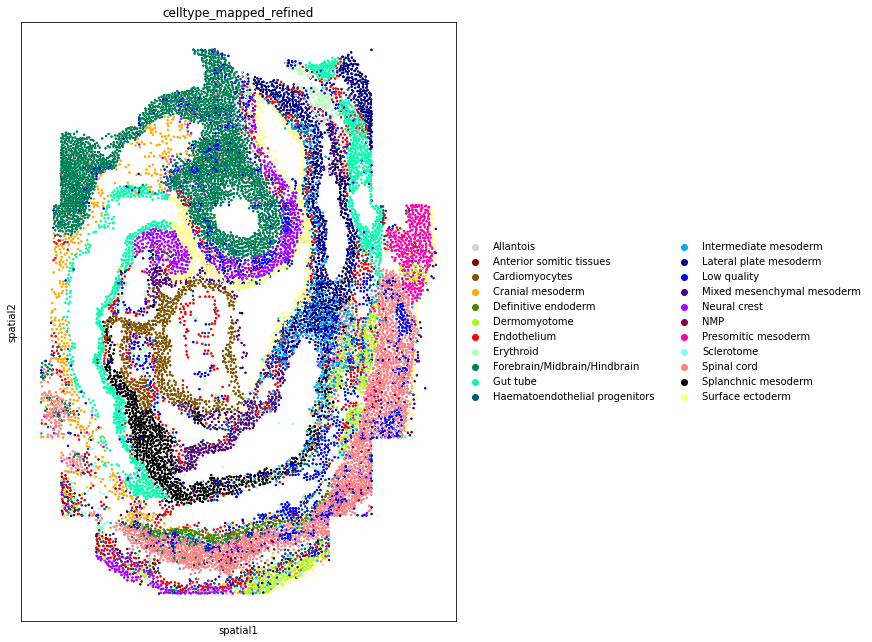

In [10]:
print(f"Using dataset {dataset}.")
print(f"Number of nodes (cells): {adata.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['counts'].shape[1]}")
avg_edges_per_node = round(adata.obsp['spatial_connectivities'].sum(axis=0).mean(), 2)
print(f"Average number of edges per node: {avg_edges_per_node}")
n_edges = int(sp.triu(adata.obsp['spatial_connectivities'], k=1).sum())
print(f"Number of total edges: {n_edges}", sep="")
print("--------------------")
# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata, color=cell_type_key, shape=None, figsize=(12, 12))

## 3. Autotalker Model with Fully Connected Gene Programs

### 3.1 Create Fully Connected Gene Program Mask

In [ ]:
# Mask that allows all genes
if node_label_method == "self":
    n_output = len(adata.var)
    gp_targets_mask = np.ones((n_latent_fc_gps, n_output))
    print(f"gp_targets_mask shape: {gp_targets_mask.shape}")
elif node_label_method != "self":
    n_output = len(adata.var) * 2
    gp_targets_mask = np.ones((n_latent_fc_gps, int(n_output / 2)))
    gp_sources_mask = np.ones((n_latent_fc_gps, int(n_output / 2)))
    print(f"gp_targets_mask shape: {gp_targets_mask.shape}.")
    print(f"gp_sources_mask shape: {gp_sources_mask.shape}.")
    
adata.uns[gp_names_key] = [f"FC_GP_{i}" for i in range(n_latent_fc_gps)]

# Determine dimensionality of hidden encoder
n_hidden_encoder = int(n_latent_fc_gps/2)

In [ ]:
# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata.uns['autotalker_gp_names'])}.")
print(f"Example gene programs: {random.sample(adata.uns['autotalker_gp_names'], 5)}.")
print(f"Number of gene program target genes: {int(gp_targets_mask[1].sum())}.")
print(f"Number of gene program source genes: {int(gp_sources_mask[1].sum())}.")

### 3.2 Initialize, Train & Save Model

In [ ]:
# Pass masks either trough ´gp_targets_mask_key´ and ´gp_sources_mask_key´ of adata or directly
model = Autotalker(adata,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   gp_names_key=gp_names_key,
                   gp_targets_mask_key=None,
                   gp_sources_mask_key=None,
                   latent_key=latent_key,
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=gp_targets_mask,
                   gp_sources_mask=(None if node_label_method == "self" else gp_sources_mask),
                   n_addon_gps=0)

In [ ]:
experiment = mlflow.set_experiment("autotalker_fc_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=n_epochs,
            lr=lr,
            weight_decay=weight_decay,
            lambda_l1_addon=lambda_l1_addon,
            lambda_group_lasso=lambda_group_lasso,
            edge_val_ratio=edge_val_ratio,
            edge_test_ratio=edge_test_ratio,
            node_val_ratio=node_val_ratio,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id,
            verbose=True)

In [ ]:
model.save(dir_path=f"./model_artefacts/{dataset}/autotalker_fc_gps_{current_timestamp}",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

## 4. Autotalker Model with Cell-Cell-Interaction (CCI) Gene Programs

### 4.1 OmniPath Ligand Receptor CCI Gene Programs

#### 4.1.1 Create OmniPath CCI Gene Program Mask

In [ ]:
# Load OmniPath ligand-receptor interactions into a gene program dictionary using the OmniPath Python API
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [ ]:
# Filter and combine OmniPath ligand receptor interaction gene programs
omnipath_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=omnipath_gp_dict,
    gp_filter_mode=None,
    combine_overlap_gps=True,
    overlap_thresh_source_genes=1.,
    overlap_thresh_target_genes=1.,
    overlap_thresh_genes=1.,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(omnipath_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(omnipath_new_gp_dict)}.")

In [ ]:
# Add the gene program dictionary as binary masks to the adata for model training
add_gps_from_gp_dict_to_adata(
    gp_dict=omnipath_new_gp_dict,
    adata=adata,
    genes_uppercase=True,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata.uns[gp_names_key])

In [ ]:
# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata.uns['autotalker_gp_names'])}.")
print(f"Example gene programs: {random.sample(list(adata.uns['autotalker_gp_names']), 5)}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_gp_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_gp_sources'].sum()}.")

#### 4.1.2 Initialize, Train & Save Model

In [ ]:
model = Autotalker(adata,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   gp_names_key=gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None,
                   n_addon_gps=0)

In [ ]:
experiment = mlflow.set_experiment("autotalker_omnipath_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=n_epochs,
            lr=lr,
            weight_decay=weight_decay,
            lambda_l1_addon=lambda_l1_addon,
            lambda_group_lasso=lambda_group_lasso,
            edge_val_ratio=edge_val_ratio,
            edge_test_ratio=edge_test_ratio,
            node_val_ratio=node_val_ratio,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id,
            verbose=True)

In [ ]:
model.save(dir_path=f"./model_artefacts/{dataset}/autotalker_omnipath_gps_{current_timestamp}",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

### 4.2 NicheNet Ligand Target Gene CCI Gene Programs

#### 4.2.1 Create NicheNet CCI Gene Program Mask

In [ ]:
# Load Nichenet ligand target gene interactions into a gene program dictionary using the NicheNet web URL
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.01,
    load_from_disk=False,
    save_to_disk=True,
    file_path=nichenet_ligand_target_mx_file_path)

In [ ]:
# Filter and combine NicheNet ligand target gene interaction gene programs
nichenet_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=nichenet_gp_dict,
    gp_filter_mode=None,
    combine_overlap_gps=True,
    overlap_thresh_source_genes=1.,
    overlap_thresh_target_genes=1.,
    overlap_thresh_genes=1.,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(nichenet_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(nichenet_new_gp_dict)}.")

In [ ]:
# Add the gene program dictionary as binary masks to the adata for model training
add_gps_from_gp_dict_to_adata(
    gp_dict=nichenet_new_gp_dict,
    adata=adata,
    genes_uppercase=True,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata.uns[gp_names_key])

In [ ]:
# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata.uns['autotalker_gp_names'])}.")
print(f"Example gene programs: {random.sample(adata.uns['autotalker_gp_names'], 5)}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_gp_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_gp_sources'].sum()}.")

#### 4.2.2 Initialize, Train & Save Model

In [ ]:
model = Autotalker(adata,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   gp_names_key=gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None,
                   n_addon_gps=0)

In [ ]:
experiment = mlflow.set_experiment("autotalker_nichenet_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=n_epochs,
            lr=lr,
            weight_decay=weight_decay,
            lambda_l1_addon=lambda_l1_addon,
            lambda_group_lasso=lambda_group_lasso,
            edge_val_ratio=edge_val_ratio,
            edge_test_ratio=edge_test_ratio,
            node_val_ratio=node_val_ratio,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id,
            verbose=True)

In [ ]:
model.save(dir_path=f"./model_artefacts/{dataset}/autotalker_nichenet_gps_{current_timestamp}",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

### 4.3 MEBOCOST Metabolite Enzyme Sensor CCI Gene Programs

#### 4.3.1 Create MEBOCOST CCI Gene Program Mask

In [ ]:
# Load MEBOCOST metabolite enzyme sensor gene interactions into a gene program dictionary
# using the data from the autotalker package
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(species="mouse",
                                                                 genes_uppercase=True)

In [ ]:
# Filter and combine MEBOCOST metabolite enzyme sensor gene interaction gene programs
mebocost_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=mebocost_gp_dict,
    gp_filter_mode=None,
    combine_overlap_gps=True,
    overlap_thresh_source_genes=1.,
    overlap_thresh_target_genes=1.,
    overlap_thresh_genes=1.,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(mebocost_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(mebocost_new_gp_dict)}.")

In [ ]:
# Add the gene program dictionary as binary masks to the adata for model training
add_gps_from_gp_dict_to_adata(
    gp_dict=mebocost_new_gp_dict,
    adata=adata,
    genes_uppercase=True,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata.uns[gp_names_key])

In [ ]:
# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata.uns['autotalker_gp_names'])}.")
print(f"Example gene programs: {random.sample(adata.uns['autotalker_gp_names'], 5)}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_gp_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_gp_sources'].sum()}.")

#### 4.3.2 Initialize, Train & Save Model

In [30]:
model = Autotalker(adata,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   gp_names_key=gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None,
                   n_addon_gps=0)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 1.0
GCN ENCODER -> n_input: 351, n_hidden: 802, n_latent: 802, n_addon_latent: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 802, n_addon_input: 0, n_output: 702, 


In [ ]:
experiment = mlflow.set_experiment("autotalker_mebocost_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=n_epochs,
            lr=lr,
            weight_decay=weight_decay,
            lambda_l1_addon=lambda_l1_addon,
            lambda_group_lasso=lambda_group_lasso,
            edge_val_ratio=edge_val_ratio,
            edge_test_ratio=edge_test_ratio,
            node_val_ratio=node_val_ratio,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id,
            verbose=True)

In [ ]:
model.save(dir_path=f"./model_artefacts/{dataset}/autotalker_mebocost_gps_{current_timestamp}",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

### 4.4 Combined Prior Knowledge CCI Gene Programs

#### 4.4.1 Create Combined Prior Knowledge CCI Gene Program Mask

In [10]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.1,
    load_from_disk=False,
    save_to_disk=True,
    file_path=nichenet_ligand_target_mx_file_path)

In [11]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [12]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    species="mouse",
    genes_uppercase=True)

In [13]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [19]:
# Filter and combine combined gene interaction gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode=None, #"subset",
    combine_overlap_gps=False, #True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")

Number of gene programs before filtering and combining: 1725.


TypeError: object of type 'NoneType' has no len()

In [ ]:
# Add the gene program dictionary as binary masks to the adata for model training
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    genes_uppercase=True,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata.uns[gp_names_key])

In [ ]:
# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata.uns['autotalker_gp_names'])}.")
print(f"Example gene programs: {random.sample(list(adata.uns['autotalker_gp_names']), 5)}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_gp_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_gp_sources'].sum()}.")

#### 4.4.2 Initialize, Train & Save Model

In [19]:
model = Autotalker(adata,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   gp_names_key=gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   log_variational=True,
                   node_label_method=node_label_method,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   n_hidden_encoder=n_hidden_encoder,
                   dropout_rate_encoder=dropout_rate_encoder,
                   dropout_rate_graph_decoder=dropout_rate_graph_decoder,
                   gp_targets_mask=None,
                   gp_sources_mask=None,
                   n_addon_gps=0)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.1
GCN ENCODER -> n_input: 351, n_hidden: 802, n_latent: 802, n_addon_latent: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 802, n_addon_input: 0, n_output: 702, 


In [20]:
n_epochs_no_edge_recon = 0
n_epochs = 1

In [21]:
experiment = mlflow.set_experiment("autotalker_combined_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=n_epochs,
            n_epochs_no_edge_recon=n_epochs_no_edge_recon,
            lr=lr,
            weight_decay=weight_decay,
            lambda_l1_addon=lambda_l1_addon,
            lambda_group_lasso=lambda_group_lasso,
            edge_val_ratio=edge_val_ratio,
            edge_test_ratio=edge_test_ratio,
            node_val_ratio=node_val_ratio,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id,
            verbose=True)

--- INITIALIZING TRAINER ---
Number of training nodes: 17474
Number of validation nodes: 1942
Number of test nodes: 0
Number of training edges: 66351
Number of validation edges: 7805
Number of test edges: 3902

--- MODEL TRAINING ---
Epoch 1/1 |████████████████████| 100.0% val_auroc_score: 0.9428; val_auprc_score: 0.9020; val_best_acc_score: 0.8097; val_best_f1_score: 0.8401; train_kl_reg_loss: 0.1680; train_edge_recon_loss: 2.7086; train_gene_expr_recon_loss: 471.2963; train_group_lasso_reg_loss: 10.5759; train_global_loss: 484.7488; train_optim_loss: 484.7488; val_kl_reg_loss: 0.1725; val_edge_recon_loss: 1.4680; val_gene_expr_recon_loss: 462.6203; val_group_lasso_reg_loss: 8.8659; val_global_loss: 473.1268; val_optim_loss: 473.1268

Model training finished after 2 min 24 sec.
Using best model state, which was in epoch 1.

--- MODEL EVALUATION ---
Test AUROC score: 0.9422
Test AUPRC score: 0.9010
Test best accuracy score: 0.8080
Test best F1 score: 0.8390


In [22]:
model.adata.obsm["autotalker_latent"].shape

(19416, 33)

In [23]:
model.save(dir_path=f"./model_artefacts/{dataset}/autotalker_combined_gps_{current_timestamp}",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

### 4.5 Learn New CCI Gene Programs

In [ ]:
model = Autotalker.load(dir_path=f"./model_artefacts/{dataset}/autotalker_combined_gps_{current_timestamp}",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        n_addon_gps=10,
                        gp_names_key=gp_names_key,
                        freeze_non_addon_weights=True)

In [ ]:
experiment = mlflow.set_experiment("autotalker_combined_denovo_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=n_epochs,
            lr=lr,
            weight_decay=weight_decay,
            lambda_l1_addon=lambda_l1_addon,
            lambda_group_lasso=lambda_group_lasso,
            edge_val_ratio=edge_val_ratio,
            edge_test_ratio=edge_test_ratio,
            node_val_ratio=node_val_ratio,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id,
            verbose=True)

In [ ]:
model.save(dir_path=f"./model_artefacts/{dataset}/autotalker_combined_denovo_gps_{current_timestamp}",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

## 5. Benchmarking

In [ ]:
# Load model
#loading_timestamp = current_timestamp
loading_timestamp = "24112022_232708"
#gp_mode = "fc_gps"
#gp_mode = "omnipath_gps"
#gp_mode = "nichenet_gps"
#gp_mode = "mebocost_gps"
gp_mode = "combined_gps"
#gp_mode = combined_denovo_gps

model = Autotalker.load(dir_path=f"./model_artefacts/{dataset}/autotalker_{gp_mode}_{loading_timestamp}",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

In [148]:
active_gps, active_gp_weights = model.get_active_gps(return_gp_weights=True)
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

Number of total gene programs: 802.
Number of active gene programs: 34.


In [149]:
active_gp_weights.norm(p=1, dim=0) / torch.count_nonzero(active_gp_weights, dim=0)

tensor([0.0634, 0.0761, 0.0825, 0.0489, 0.0777, 0.0730, 0.0391, 0.0738, 0.0277,
        0.0758, 0.0612, 0.0799, 0.0646, 0.0526, 0.0876, 0.0964, 0.0938, 0.0972,
        0.0250, 0.0594, 0.2016, 0.0787, 0.0481, 0.0381, 0.5213, 0.2629, 0.1731,
        0.0948, 0.3395, 0.5901, 0.4834, 0.3749, 0.3936, 0.3617],
       device='cuda:0')

In [150]:
active_gps

array(['CTF1_ligand_targetgenes_GP', 'TSLP_ligand_targetgenes_GP',
       'IL10_ligand_targetgenes_GP', 'IL20_ligand_targetgenes_GP',
       'IFNL1_ligand_targetgenes_GP', 'IL17F_ligand_targetgenes_GP',
       'COL1A1_ligand_targetgenes_GP', 'CSHL1_ligand_targetgenes_GP',
       'BMP15_ligand_targetgenes_GP', 'DLL4_ligand_targetgenes_GP',
       'IL12B_ligand_targetgenes_GP', 'LEFTY2_ligand_targetgenes_GP',
       'SHH_ligand_targetgenes_GP', 'GPNMB_ligand_targetgenes_GP',
       'CRLF2_ligand_targetgenes_GP', 'VGF_ligand_targetgenes_GP',
       'WISP2_ligand_targetgenes_GP', 'IL27_ligand_targetgenes_GP',
       'LEFTY1_ligand_targetgenes_GP', 'SFRP2_ligand_targetgenes_GP',
       'SECTM1_ligand_targetgenes_GP', 'GDF3_ligand_targetgenes_GP',
       'CD226_ligand_targetgenes_GP', 'CDH18_ligand_targetgenes_GP',
       'NOTCH1_ligand_receptor_GP', 'WNT5A_ligand_receptor_GP',
       'BMP4_ligand_receptor_GP', 'BMP7_ligand_receptor_GP',
       'DLL1_ligand_receptor_GP', 'LFNG_ligand_recepto

In [ ]:
acc = compute_cell_cat_cls_accuracy(adata=model.adata,
                                    cat_key="celltype_mapped_refined",
                                    gp_names_key="autotalker_gp_names",
                                    latent_key="autotalker_latent",
                                    selected_gps=active_gps, 
                                    #selected_gps=None, 
                                    #selected_gps=["BMP7_ligand_targetgenes_GP"],
                                    selected_cats=None, # ["Cardiomyocytes"],
                                    n_features_gt_n_samples=False,
                                    seed=random_seed)

In [ ]:
print(acc)

### 5.1 Graph Connectivity Distance (GCD)

Measures the edge preservation in the latent space vs the physical space.

In [151]:
avg_gcd_list = []

avg_gcd_list.append(compute_avg_gcd(adata=model.adata,
                          spatial_key=spatial_key,
                          latent_key=latent_key,
                          seed=random_state))

NameError: name 'spatial_key' is not defined

In [ ]:
plt.scatter(avg_gcd_list)

In [ ]:
avg_gcd = compute_avg_gcd(adata=adata,
                          spatial_key=spatial_key,
                          latent_key=latent_key,
                          seed=random_state)
print("Average graph connectivity distance:", avg_gcd)

### 5.2 Leiden Normalized Mutual Info (LNMI)

Measures the preservation of spatial organization by comparing cluster overlaps between the latent space and physical space.

In [ ]:
max_lnmi = compute_max_lnmi(adata=model.adata,
                            spatial_key=spatial_key,
                            latent_key=latent_key,
                            seed=random_state,
                            visualize_leiden_clustering=True)
print(f"Maximum Leiden Normalized Mutual Info: {max_lnmi}.")

### 5.3 Cell-type Affinity Distance (CAD)

Measures preservation of cell-cell contact maps, that means cell-type enrichments in a cell’s neighborhood across all cells, in latent space vs physical space.

In [ ]:
avg_cad = compute_avg_cad(adata=adata,
                          cell_type_key=cell_type_key,
                          spatial_key=spatial_key,
                          latent_key=latent_key,
                          seed=random_state)
print("Average cell-type affinity distance:", avg_cad)

In [ ]:
cad = compute_cad(adata=adata,
                  cell_type_key=cell_type_key,
                  spatial_key=spatial_key,
                  latent_key=latent_key,
                  n_neighbors=15,
                  seed=random_state,
                  visualize_ccc_maps=True)
print("Cell-type affinity distance:", cad)

### 5.4 Relative Cell-type Local Inverse Simpson's Index (RCLISI)

Measures preservation of spatial cell-type heterogeneity in latent space vs physical space.

In [ ]:
per_cell_log_rclisi_df = compute_per_cell_log_rclisi(adata=adata,
                                                     cell_type_key=cell_type_key,
                                                     spatial_key=spatial_key,
                                                     latent_key=latent_key,
                                                     n_neighbors=15,
                                                     seed=random_state)

In [ ]:
sns.displot(per_cell_log_rclisi_df, x="log_rclisi", kind="kde", bw_adjust=2, height=3, aspect=10)

### 5.5 Gene Expression Reconstruction (GER)

## 6. Analysis

In [24]:
# Use autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata, min_dist=0.3)

### 6.1 Cell-type Annotations in Physical and Latent Space

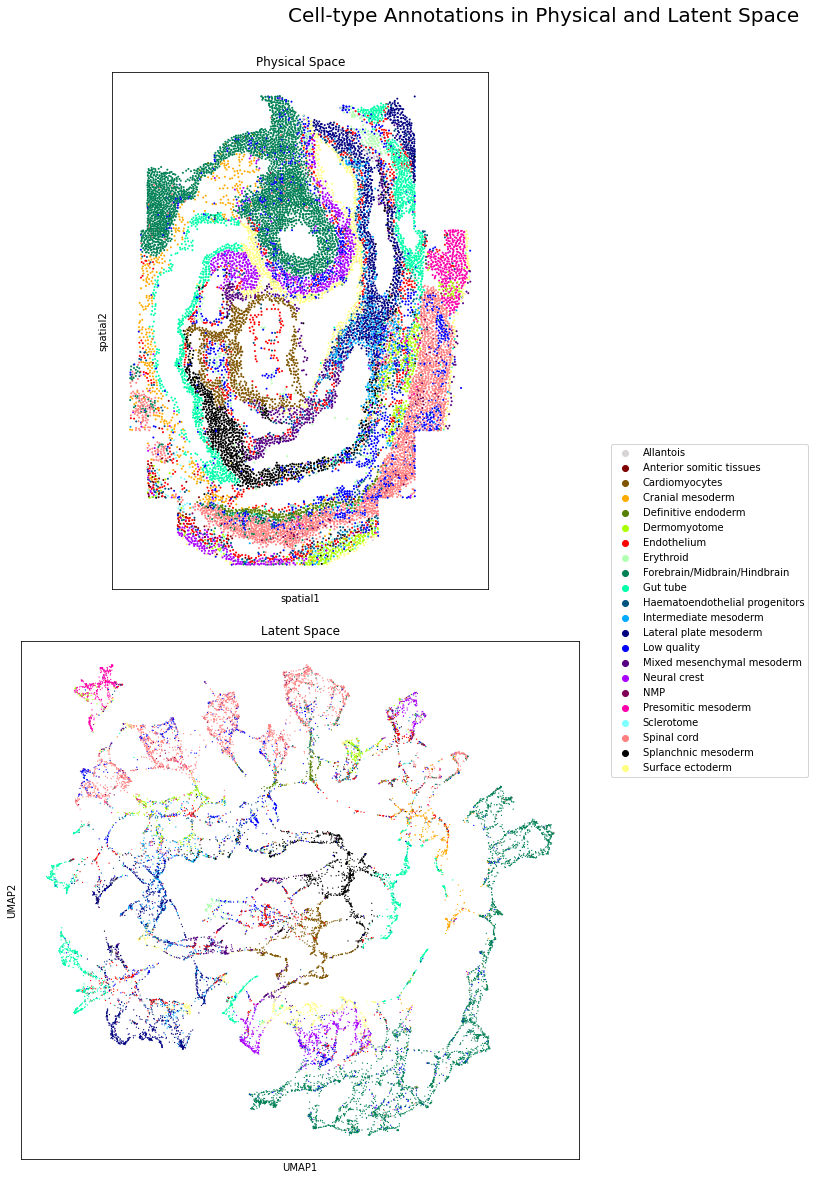

In [25]:
# Create subplot of cell-type annotations in physical and latent space
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))
title = fig.suptitle(t="Cell-type Annotations in Physical and Latent Space",
                     x=0.85,
                     y=0.925,
                     fontsize=20)
sc.pl.spatial(adata=model.adata,
              color=[cell_type_key],
              spot_size=0.03,
              title="Physical Space",
              ax=axs[0],
              show=False)
sc.pl.umap(adata=model.adata,
           color=[cell_type_key],
           title="Latent Space",
           ax=axs[1],
           show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.225, 0.625))
axs[0].get_legend().remove()
axs[1].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig(f"figures/analysis/{dataset}/cell_type_annotations_in_physical_and_latent_space_{current_timestamp}.png",
            bbox_extra_artists=(lgd, title),
            bbox_inches="tight")
plt.show()

### 6.2 Latent Leiden Cluster Annotations in Latent and Physical Space

In [26]:
model.compute_latent_graph_connectivities(adata=model.adata,
                                          n_neighbors=8,
                                          mode="knn",
                                          seed=random_seed)

In [27]:
# Compute latent Leiden clustering
resolution = 0.3

sc.tl.leiden(adata=model.adata,
             resolution=resolution,
             random_state=random_seed,
             key_added=f"latent_leiden_{str(resolution)}",
             adjacency=model.adata.obsp["latent_connectivities"])

# Compute UMAP for latent Leiden clusters
sc.pp.neighbors(adata=model.adata, use_rep=latent_key)
sc.tl.umap(adata=model.adata, min_dist=0.3)

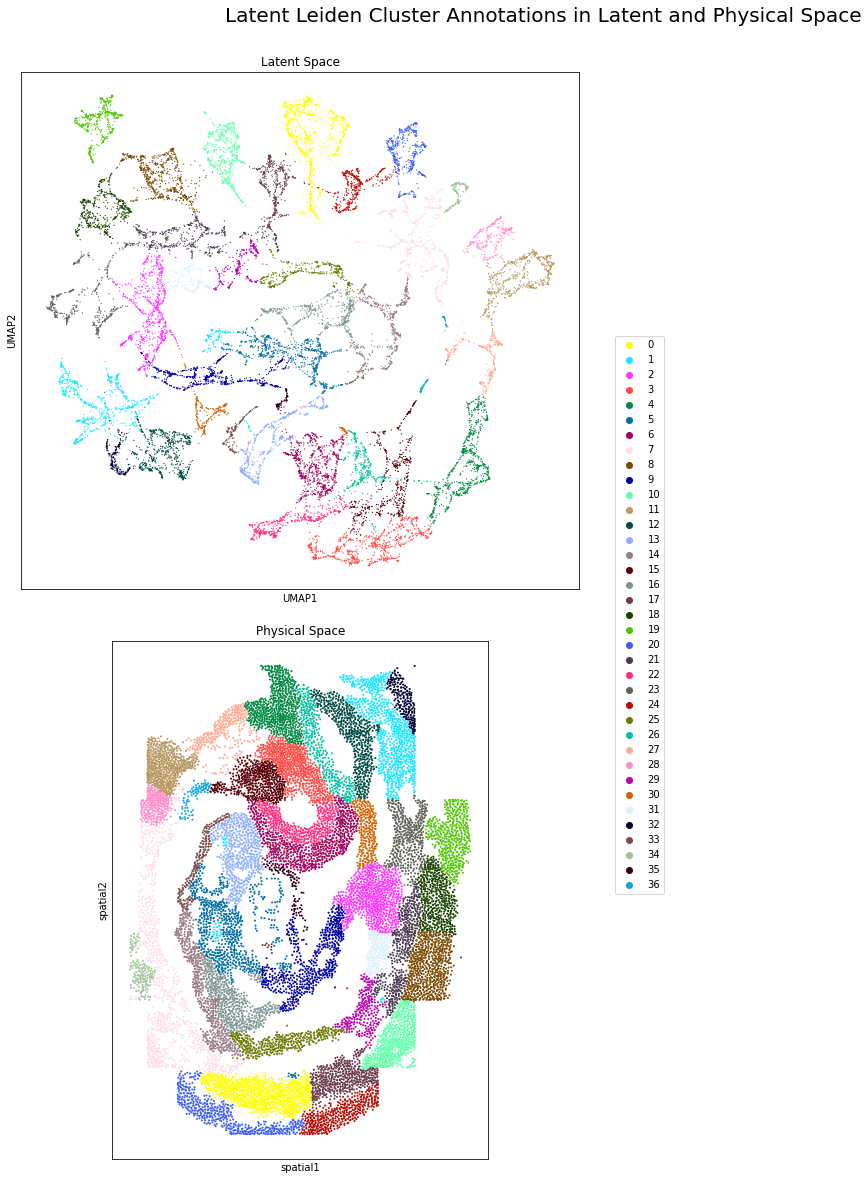

In [28]:
# Create subplot of latent Leiden cluster annotations in physical and latent space
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))
title = fig.suptitle(t="Latent Leiden Cluster Annotations in Latent and Physical Space",
                     x=0.85,
                     y=0.925,
                     fontsize=20)
sc.pl.umap(adata=model.adata,
           color=[f"latent_leiden_{str(resolution)}"],
           color_map="magma",
           title=f"Latent Space",
           ax=axs[0],
           show=False)
sc.pl.spatial(adata=model.adata,
              color=[f"latent_leiden_{str(resolution)}"],
              color_map="magma",
              spot_size=0.03,
              title=f"Physical Space",
              ax=axs[1],
              show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.025, 0.7))
axs[0].get_legend().remove()
axs[1].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig(f"figures/analysis/{dataset}/latent_leiden_cluster_annotations_in_latent_and_physical_space_{current_timestamp}.png",
            bbox_extra_artists=(lgd, title),
            bbox_inches="tight")
plt.show()

### 6.3 Gene Program Enrichments

#### 6.3.1 Cell-type Gene Program Enrichments

In [29]:
differential_gp_scores_key = "autotalker_cell_type_differential_gp_scores"
n_top_up_gps = 6
n_top_down_gps = 6

##### 6.3.1.1 Explore All GPs Across All Categories

In [32]:
# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_key,
                                                      adata=model.adata,
                                                      selected_gps=None,
                                                      selected_cats=None,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats="rest",
                                                      n_sample=1000,
                                                      key_added=differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

In [33]:
# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

,category,gene_program,p_h0,p_h1,log_bayes_factor
0,Presomitic mesoderm,CSH1_ligand_targetgenes_GP,0.956849,0.043151,3.098939
1,Gut tube,CSH1_ligand_targetgenes_GP,0.877965,0.122035,1.973299
2,Presomitic mesoderm,COL4A1_ligand_targetgenes_GP,0.839673,0.160327,1.655799
3,Cranial mesoderm,CSH1_ligand_targetgenes_GP,0.833763,0.166237,1.612531
4,Cranial mesoderm,TSLP_ligand_targetgenes_GP,0.750565,0.249435,1.101628
5,Dermomyotome,CSH1_ligand_targetgenes_GP,0.747794,0.252206,1.086883


In [34]:
# Display top downregulated gene programs
top_down_gp_df = adata.uns[differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

,category,gene_program,p_h0,p_h1,log_bayes_factor
725,Erythroid,CSH1_ligand_targetgenes_GP,0.152073,0.847927,-1.718434
724,Cranial mesoderm,WISP2_ligand_targetgenes_GP,0.209495,0.790505,-1.327970
723,Cardiomyocytes,CSH1_ligand_targetgenes_GP,0.211408,0.788592,-1.316460
722,Allantois,COL4A1_ligand_targetgenes_GP,0.237226,0.762774,-1.167951
721,Cardiomyocytes,TSLP_ligand_targetgenes_GP,0.251331,0.748669,-1.091528
720,Mixed mesenchymal mesoderm,COL4A1_ligand_targetgenes_GP,0.262962,0.737038,-1.030630


         Falling back to preprocessing with `sc.pp.pca` and default params.


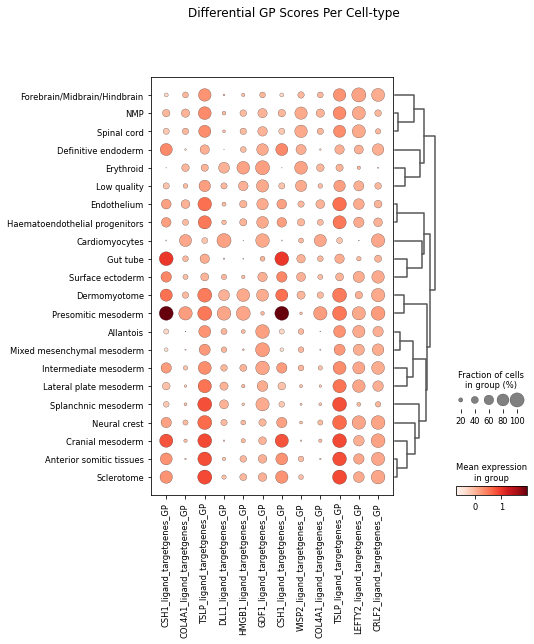

In [35]:
fig = sc.pl.dotplot(adata,
                    top_unique_gps,
                    groupby=cell_type_key,
                    dendrogram=True, 
                    title="Differential GP Scores Per Cell-type",
                    return_fig=True)

# Save and display plot
fig.savefig(f"figures/analysis/{dataset}/differential_gp_scores_per_cell_type_all_categories_{current_timestamp}.png")
plt.show()

In [36]:
top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()
top_genes = []

for gp in top_gps:
    top_genes.append(
        model.compute_gp_gene_importances(selected_gp=gp)["gene"][0])

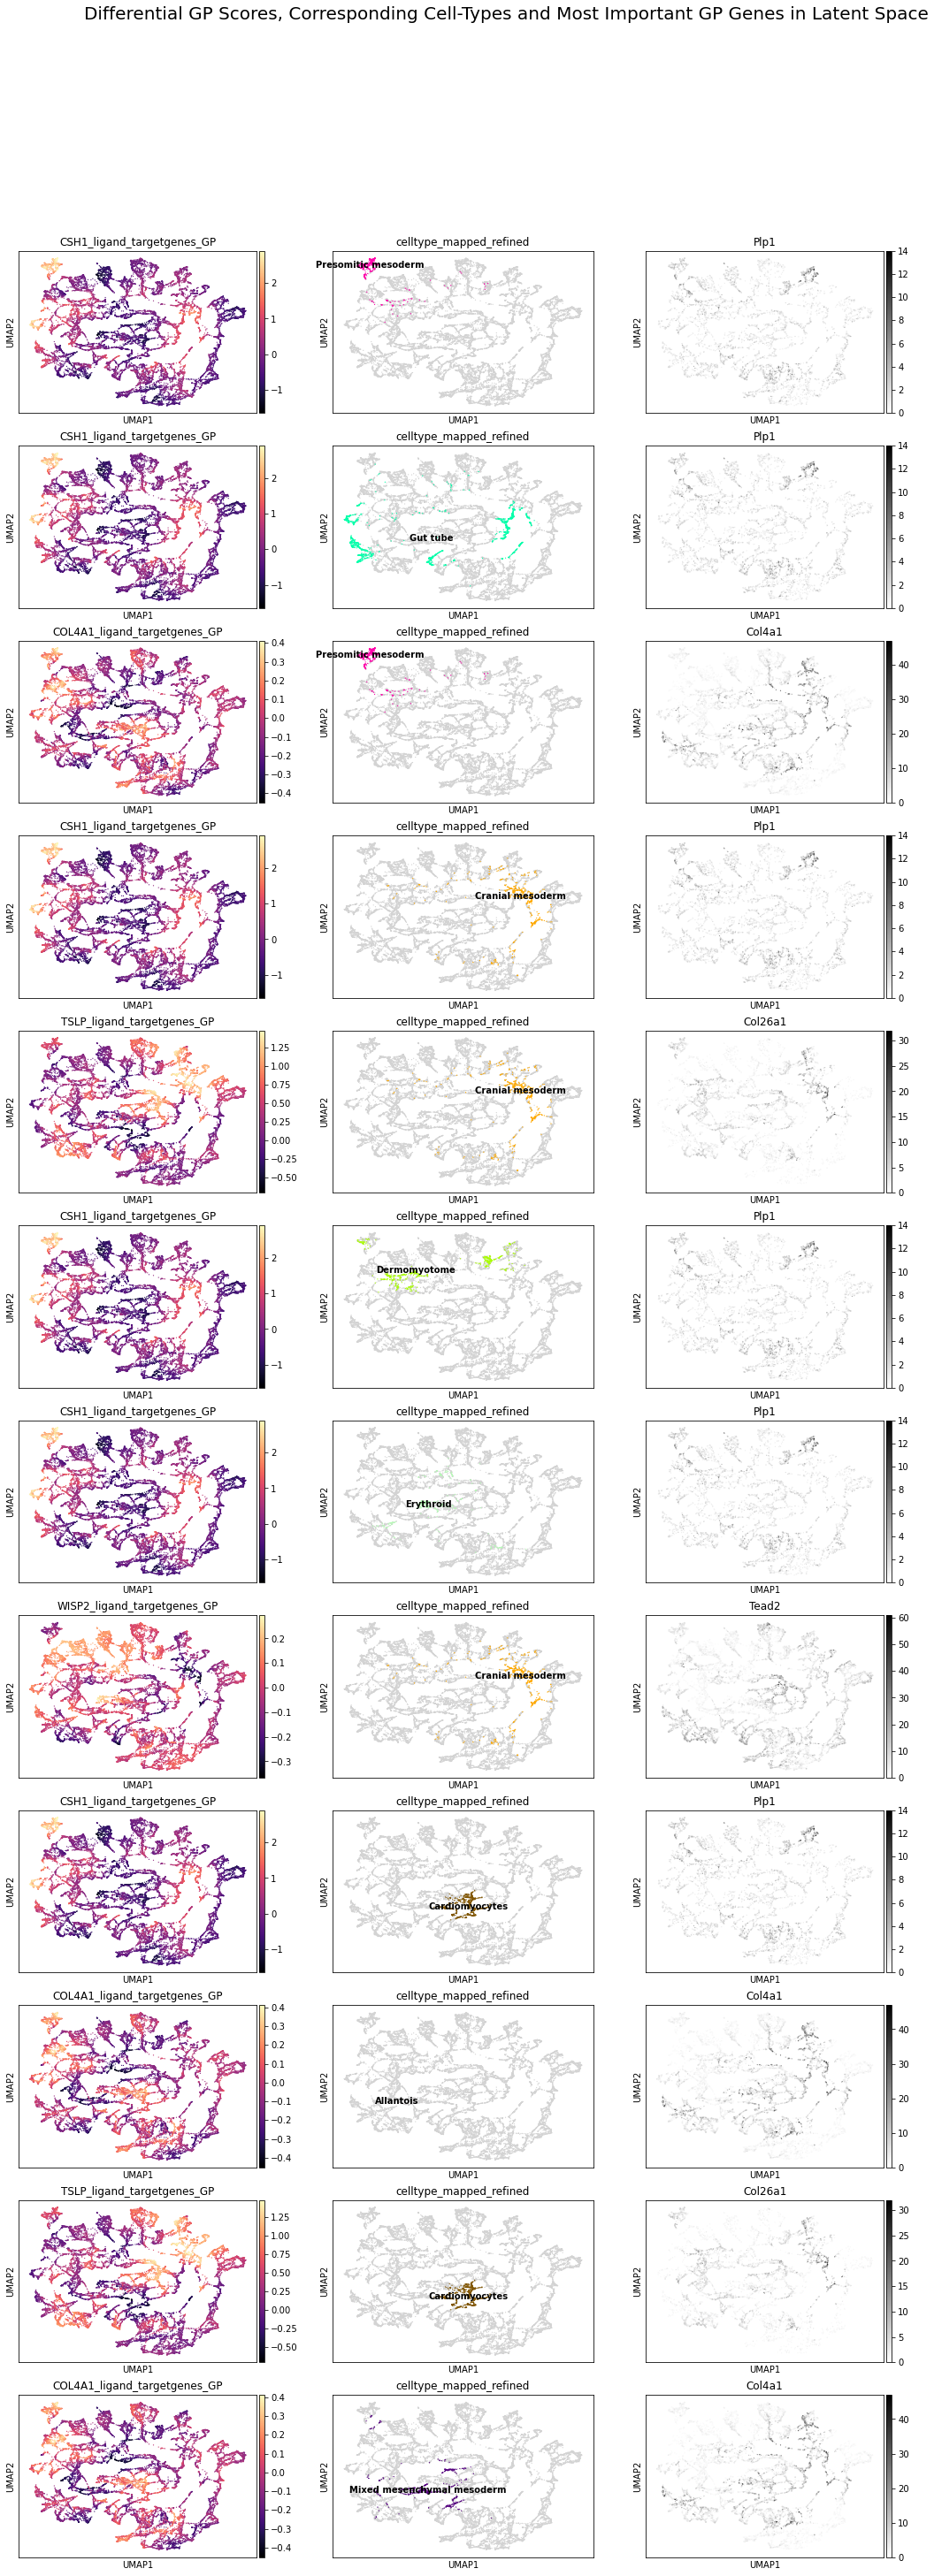

In [38]:
# Plot selected gene program latent scores
fig, axs = plt.subplots(nrows=n_top_up_gps+n_top_down_gps, ncols=3, figsize=(18, 4*len(top_gps)))
title = fig.suptitle(t="Differential GP Scores, Corresponding Cell-Types and Most Important GP Genes in Latent Space",
                     x=0.55,
                     y=0.96,
                     fontsize=20)
for i in range(len(top_gps)):
    sc.pl.umap(adata, color=top_gps[i], color_map="magma", ax=axs[i, 0], show=False)
    sc.pl.umap(adata,
               color=[cell_type_key],
               color_map="magma",
               groups=top_cats[i],
               ax=axs[i, 1],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    sc.pl.umap(adata,
               color=top_genes[i],
               color_map="binary",
               ax=axs[i, 2],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    
# Save and display plot
fig.savefig(f"figures/analysis/{dataset}/cell_type_gp_scores_cell_types_most_important_genes_{current_timestamp}.png",
            bbox_extra_artists=(title,),
            bbox_inches="tight")
plt.show()

##### 6.3.1.2 Explore All GPs Across Specific Categories

In [ ]:
selected_cats = ["Erythroid", "Endothelium"]

In [ ]:
# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_gps = model.compute_differential_gp_scores(cat_key=cell_type_key,
                                               adata=adata,
                                               selected_gps=None,
                                               selected_cats=selected_cats,
                                               gp_scores_weight_normalization=False,
                                               gp_scores_zi_normalization=False,
                                               comparison_cats="rest",
                                               n_sample=1000,
                                               key_added=differential_gp_scores_key,
                                               n_top_up_gps_retrieved=n_top_up_gps,
                                               n_top_down_gps_retrieved=n_top_down_gps,
                                               seed=random_seed)

In [ ]:
# Display top upregulated gene programs
adata.uns[differential_gp_scores_key][:n_top_up_gps]

In [ ]:
# Display top downregulated gene programs
adata.uns[differential_gp_scores_key][-n_top_down_gps:][::-1]

In [ ]:
fig = sc.pl.dotplot(adata,
                    top_gps,
                    groupby=cell_type_key,
                    dendrogram=True, 
                    title="Differential GP Scores Per Cell-type",
                    return_fig=True)

# Save and display plot
fig.savefig(f"figures/analysis/{dataset}/differential_gp_scores_per_cell_type_specific_categories_{current_timestamp}.png")
plt.show()

In [ ]:
# Plot selected gene program latent scores
fig, axs = plt.subplots(nrows=n_top_up_gps+n_top_down_gps, ncols=3, figsize=(18,4*(n_top_up_gps+n_top_down_gps)))
title = fig.suptitle("Enriched GP Scores, Corresponding Cell-Types and Most Important GP Genes in Latent Space", x=0.55, y=0.96)
for i in range(len(selected_gps)):
    sc.pl.umap(adata, color=selected_gps[i], color_map="magma", ax=axs[i, 0], show=False)
    sc.pl.umap(adata,
               color=[cell_type_key],
               color_map="magma",
               groups=selected_cell_types[i],
               ax=axs[i, 1],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    sc.pl.umap(adata,
               color=selected_genes[i],
               color_map="binary",
               ax=axs[i, 2],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    
# Save and display plot
fig.savefig(f"figures/analysis/{dataset}/enriched_cell_type_gp_scores_and_most_important_genes_{current_timestamp}.png",
            bbox_extra_artists=(title,),
            bbox_inches="tight")
plt.show()

In [ ]:
# Split gene program enrichments per gene program type
cell_type_ligand_receptor_gp_enrichment_df = cell_type_gp_enrichment_df[
    adata.uns[gp_enrichment_scores_key]["gene_program"].str.contains("ligand_receptor")].reset_index()

cell_type_ligand_targetgene_gp_enrichment_df = cell_type_gp_enrichment_df[
    adata.uns[gp_enrichment_scores_key]["gene_program"].str.contains("ligand_targetgenes")].reset_index()

cell_type_metabolite_enzyme_sensor_gp_enrichment_df = cell_type_gp_enrichment_df[
    adata.uns[gp_enrichment_scores_key]["gene_program"].str.contains("metabolite_enzyme_sensor")].reset_index()

##### 6.3.1.3 Explore Specific GPs

In [ ]:
selected_gps = ["BMP7_ligand_receptor_GP", "EPOR_ligand_receptor_GP"]

In [ ]:
# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_gps = model.compute_differential_gp_scores(cat_key=cell_type_key,
                                               adata=adata,
                                               selected_gps=selected_gps,
                                               gp_scores_weight_normalization=False,
                                               gp_scores_zi_normalization=False,
                                               comparison_cats="rest",
                                               n_sample=1000,
                                               key_added=differential_gp_scores_key,
                                               n_top_up_gps_retrieved=n_top_up_gps,
                                               n_top_down_gps_retrieved=n_top_down_gps,
                                               seed=random_seed)

In [ ]:
# Display top upregulated gene programs
adata.uns[differential_gp_scores_key][:n_top_up_gps]

In [ ]:
# Display top downregulated gene programs
adata.uns[differential_gp_scores_key][-n_top_down_gps:][::-1]

In [ ]:
fig = sc.pl.dotplot(adata,
                    selected_gps,
                    groupby=cell_type_key,
                    dendrogram=True, 
                    title="Differential GP Scores Per Cell-type",
                    return_fig=True)

# Save and display plot
fig.savefig(f"figures/analysis/{dataset}/differential_gp_scores_per_cell_type_specific_gps_{current_timestamp}.png")
plt.show()

In [ ]:
selected_gps = ["BMP7_ligand_receptor_GP"]
cell_type = "Cardiomyocytes"
top_gene = model.compute_gp_gene_importances(gp_name=selected_gps[0],
                                             gp_names_key=gp_names_key)["gene"][0]

selected_gps_idx = [gps.index(gp) for gp in selected_gps]
latent_selected_gps = latent[:, selected_gps_idx]
for i, gp in enumerate(selected_gps):
    adata.obs[gp] = latent_selected_gps[:, i]

In [ ]:
sc.pl.umap(adata, color=selected_gps[0], color_map="magma")
sc.pl.umap(adata,
           color=[cell_type_key],
           color_map="magma",
           groups=cell_type,
           legend_loc="on data",
           na_in_legend=False)
sc.pl.umap(adata,
           color=top_gene,
           color_map="binary",
           legend_loc="on data",
           na_in_legend=False)

In [ ]:
sc.pl.scatter(adata, x="CSF1_ligand_targetgenes_GP", y="IL34_ligand_targetgenes_GP", color=cell_type_key, size=10)

#### 6.3.2 Spatial Gene Program Enrichment Scores

#### 6.3.3 Gene Program Gene Importances

In [ ]:
selected_gp = ["BMP7_ligand_receptor_GP"]

In [ ]:
gene_importances_df = model.compute_gp_gene_importances(
    selected_gp="BMP7_ligand_receptor_GP",
    adata=None,
    gene_importances_zi_normalization=True)

display(gene_importances_df)

In [ ]:
genes = list(gene_importances_df["gene"])

for gene in genes:
    sc.pl.umap(adata,
               color=gene,
               color_map="binary",
               legend_loc="on data",
               na_in_legend=False)